<a href="https://colab.research.google.com/github/saritmaitra/Absolute_Price_Oscillator/blob/main/Support_Resistance_Changepoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import datetime
import numpy as np
import pandas as pd
import sklearn
!pip install yfinance
import os
import yfinance as yf
import gc
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import statistics as stats
import math as math
!pip install ruptures
import ruptures as rpt
from statistics import stdev

In [2]:
def time_series():
  # We would like all available data from 01/01/2000 until 12/31/2016.
  start_date = '2020-01-01'
  
  # Obtain stock information from Yahoo Finance
  ts = yf.download('SGRY', start=start_date) # interval = "60m",
  return ts
  
ts = time_series()
ts.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-28,67.389999,67.599998,65.150002,66.550003,66.550003,422500
2021-06-29,67.059998,68.250000,65.581001,65.900002,65.900002,423800
2021-06-30,65.440002,67.199997,64.639999,66.620003,66.620003,308200
2021-07-01,66.519997,67.230003,64.779999,65.199997,65.199997,342300
2021-07-02,64.970001,65.754997,63.810001,65.330002,65.330002,260700


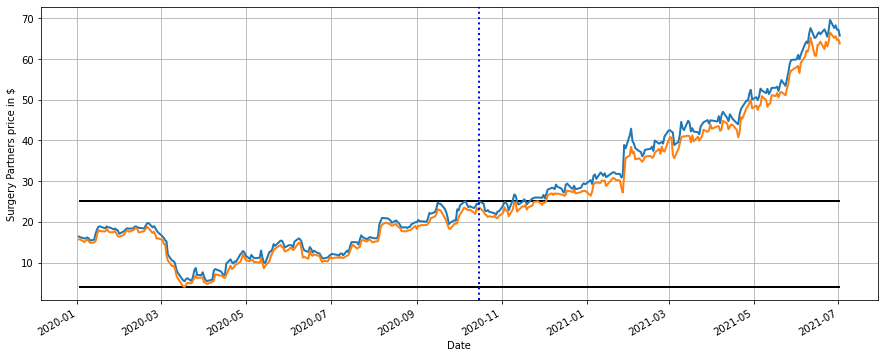

In [7]:
SGRY_data = ts.tail(620)
lows = ts['Low']
highs = ts['High']

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111, ylabel='Surgery Partners price in $')
highs.plot(ax=ax1, lw=2.)
lows.plot(ax=ax1, lw=2.)
plt.hlines(highs.head(200).max(),lows.index.values[0],lows.index.values[-1] ,linewidth=2, )
plt.hlines(lows.head(200).min(),lows.index.values[0],lows.index.values[-1], linewidth=2, )
plt.axvline(linewidth=2,color='b',x=lows.index.values[200],linestyle=':')
plt.grid(True);plt.show()


- the highs and lows of the SGRY price.
- The green line represents the resistance level, and the red line represents the support level.
- used the maximum and minimum price to built thie plot.
- After the 200th day (dotted vertical blue line), we will buy when we reach the
support line, and sell when we reach the resistance line. In this example, we used
- 200 days so that we have sufficient data points to get an estimate of the trend.
- As per this plot it can be observed that the SGRY price will reach the resistance line around Dec 2020. This means that we have a signal to enter a short position (sell).
- Once traded, we will wait to get out of this short position when the price
will reach the support line.
- With this historical data, it is easily noticeable that this condition will not happen.
- This will result in carrying a short position in a rising market without having any signal to sell it, thereby resulting in a huge loss.
- This means that, even if the trading idea based on support/resistance has strong grounds in terms of economical behavior, in reality, we need to modify this strategy to make it work.
- Moving the support/resistance line to adapt to the market evolution will be key to the strategy efficiency

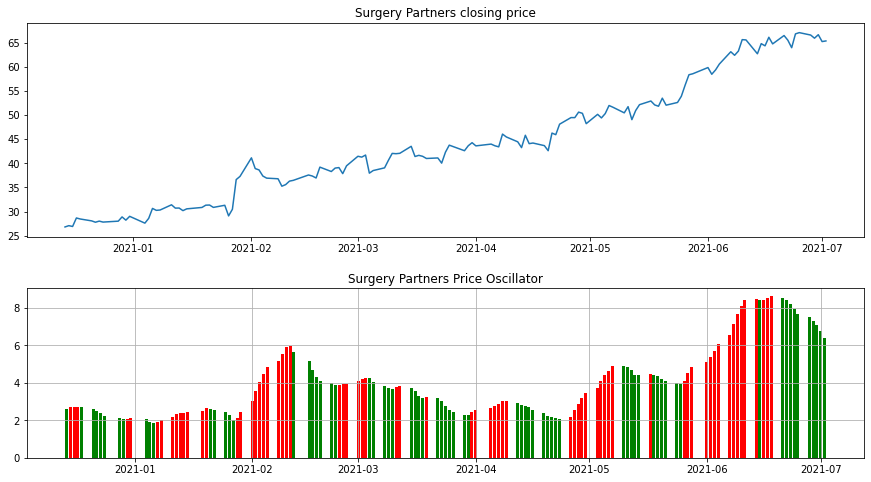

In [25]:
def ema(price, period):
    ema = price.rolling(period).mean()
    return ema

def po(price, period1, period2):
    median = price.rolling(2).median()
    short = ema(median, period1)
    long = ema(median, period2)
    po = short - long
    po_df = pd.DataFrame(po).rename(columns = {'Close':'po'})
    return po_df

ts['po'] = po(ts['Adj Close'], 10, 40)
ts.dropna(inplace=True)

plt.figure(figsize=(15,8))
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((10,1), (6,0), rowspan = 4, colspan = 1)
ax1.plot(ts['Adj Close'])
ax1.set_title('Surgery Partners closing price')
for i in range(len(ts)):
    if ts['po'][i-1] > ts['po'][i]:
        ax2.bar(ts.index[i], ts['po'][i], color = 'green')
    else:
        ax2.bar(ts.index[i], ts['po'][i], color = 'red')
ax2.set_title('Surgery Partners Price Oscillator')
plt.grid(True); plt.show()

We will create a short signal when the price reaches its lowest point. We will get out of a position by having the price crossing the moving average of the last window_size days. This code starts the turtle_trading function by creating a column to store the highs, the lows, and the average with a rolling window
window_size:

In [9]:
# data collection
SGRY_signal = pd.DataFrame(index=ts.index)
SGRY_signal['price'] = ts['Adj Close']

In [10]:
from statistics import *
 
different_simulations= []
data = SGRY_signal
i_range = [x for x in range(1, 45)]

def trading_support_resistance(data, t_window=20):          #1
    data['sup_tolerance'] = pd.Series(np.zeros(len(data)))
    data['res_tolerance'] = pd.Series(np.zeros(len(data)))
    data['sup_count'] = pd.Series(np.zeros(len(data)))
    data['res_count'] = pd.Series(np.zeros(len(data)))
    data['sup'] = pd.Series(np.zeros(len(data)))
    data['res'] = pd.Series(np.zeros(len(data)))
    data['positions'] = pd.Series(np.zeros(len(data)))
    data['signal'] = pd.Series(np.zeros(len(data)))
    in_support=0
    in_resistance=0
 
    for x in range((t_window - 1) + t_window, len(data)):   #2
        data_section = data[x - t_window:x + 1]             #3 
        support_level=min(data_section['price'])            #4
        resistance_level=max(data_section['price'])
        range_level=resistance_level-support_level
        data['res'][x]=resistance_level
        data['sup'][x]=support_level
        data['sup_tolerance'][x]=support_level + 0.2 * range_level
        data['res_tolerance'][x]=resistance_level - 0.2 * range_level
                                                            #5
        if data['price'][x]>=data['res_tolerance'][x] and\
                                data['price'][x] <= data['res'][x]:   
            in_resistance+=1
            data['res_count'][x]=in_resistance  
        elif data['price'][x] <= data['sup_tolerance'][x] and\
                                data['price'][x] >= data['sup'][x]:
            in_support+=1
            data['sup_count'][x] = in_support
        else:
            in_support=0
            in_resistance=0
 
        if in_resistance>2:                                 #6
            data['signal'][x]=1
        elif in_support>2:
            data['signal'][x]=0
        else:
            data['signal'][x] = data['signal'][x-1]
 
    data['positions']=data['signal'].diff()
 
trading_support_resistance(SGRY_signal)


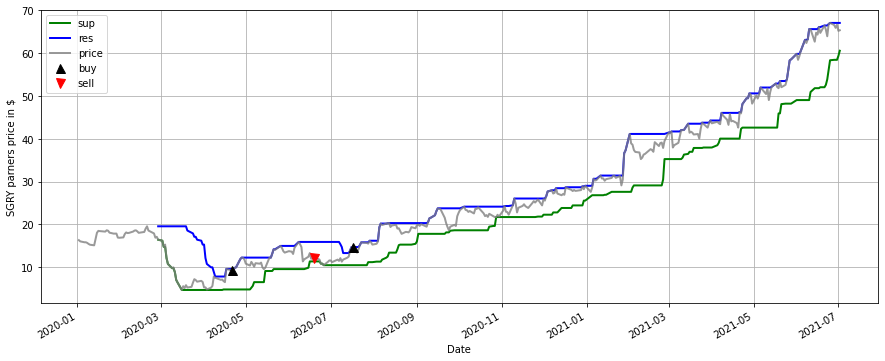

(None, None)

In [11]:
# sns.set(font_scale=1.25) 
 
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111, ylabel='SGRY parners price in $')
SGRY_signal['sup'].plot(ax=ax1, color='g', lw=2.)
SGRY_signal['res'].plot(ax=ax1, color='b', lw=2.)
SGRY_signal['price'].plot(ax=ax1, color='gray', alpha=0.8, lw=2.)
ax1.plot(SGRY_signal.loc[SGRY_signal.positions == 1.0].index,
    SGRY_signal.price[SGRY_signal.positions == 1.0],
    '^', markersize=9, color='k', label='buy')
ax1.plot(SGRY_signal.loc[SGRY_signal.positions == -1.0].index,
    SGRY_signal.price[SGRY_signal.positions == -1.0],
    'v', markersize=9, color='r', label='sell')
plt.legend(); plt.grid(True), plt.show()
# plt.savefig('strategy.png', dpi=300)

In [12]:
SGRY_signal['buy_sell'] = SGRY_signal['signal'].replace(0,-1)
 
SGRY_signal['actual_returns'] = np.log(SGRY_signal['price']/SGRY_signal['price'].shift(1))
Cum_returns = SGRY_signal['actual_returns'].cumsum()*100 
SGRY_signal['strategy_returns'] = SGRY_signal['actual_returns'] * SGRY_signal['buy_sell'].shift(1)
Cum_strategy_returns = SGRY_signal['strategy_returns'].cumsum()*100

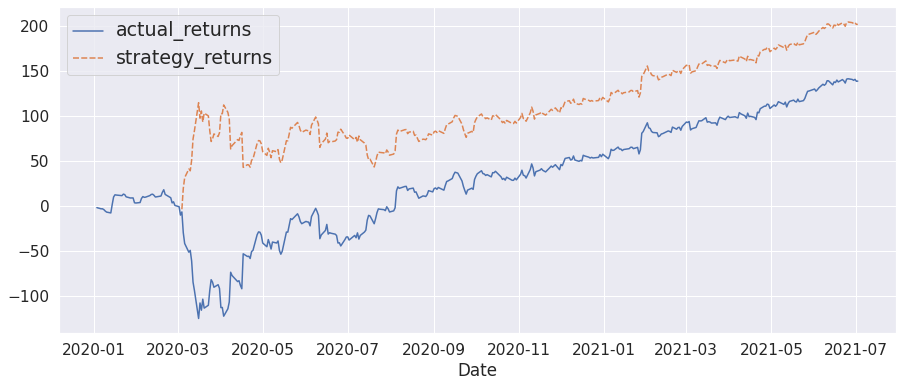

In [13]:
import seaborn as sns
newdf = pd.concat([Cum_returns, Cum_strategy_returns], axis=1)
 
plt.figure(figsize=(15, 6))
sns.set(font_scale=1.4) 
ax = sns.lineplot(data=newdf)
plt.setp(ax.get_legend().get_texts(), fontsize='19')
plt.grid(True); plt.show()
#plt.savefig('returns20.png', dpi=300)

In [18]:
close_price = ts['Adj Close']

In [21]:
time_period = 20 # look back period
history = [] # history of prices
sma_values = [] # to track moving average values for visualization purposes
stddev_values = [] # history of computed stdev values
for price in close_price:
  history.append(price)

  if len(history) > time_period: # we track at most 'time_period' number of prices
    del (history[0])
  
  sma = stats.mean(history)
  sma_values.append(sma)
  variance = 0 # variance is square of standard deviation
for hist_price in history:
  variance = variance + ((hist_price - sma) ** 2)
stdev = math.sqrt(variance / len(history))
stddev_values.append(stdev)

In [40]:
window_size = 20

# data collection
SGRY_data = pd.DataFrame(index=ts.index)
SGRY_data['price'] = ts['Adj Close']
SGRY_data['stddev'] = ts['Adj Close'].rolling(window=window_size).std()
SGRY_data.tail()


,price,stddev
Date,,
2021-06-28,66.550003,2.614402
2021-06-29,65.900002,2.472161
2021-06-30,66.620003,2.130870
2021-07-01,65.199997,1.742644
2021-07-02,65.330002,1.420532


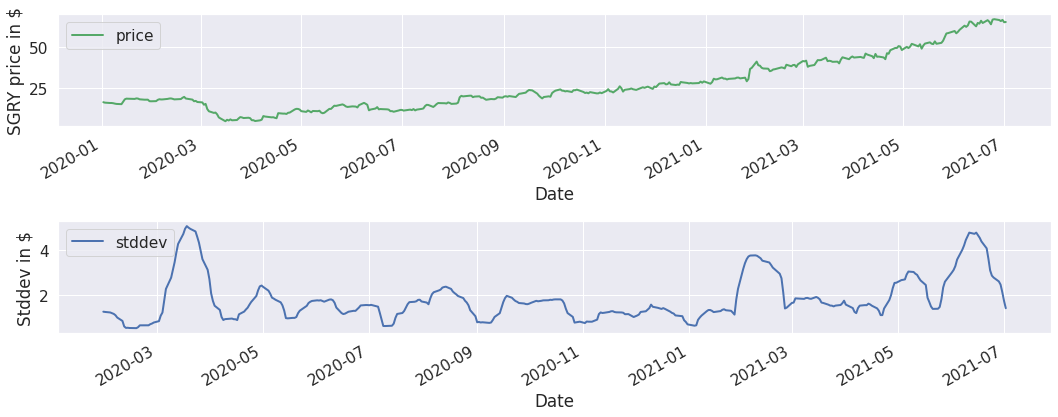

In [32]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211, ylabel='SGRY price in $')
SGRY_data['price'].plot(ax=ax1, color='g', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='Stddev in $')
SGRY_data['stddev'].plot(ax=ax2, color='b', lw=2., legend=True)
plt.tight_layout();plt.show()

Here, the standard deviation quantifies the volatility in the price moves during the last 20 days. Volatility spikes when the SGRY partners prices spike up or spike down or go through large changes over the last 20 days. 

In [21]:
#Convert the time series values to a numpy 1D array
points=np.array(ts['Adj Close'])

Pruned Exact Linear Time (PELT) search method: The PELT method is an exact method, and generally produces quick and consistent results. It detects change points through the minimization of costs (4). The algorithm has a computational cost of O(n), where n is the number of data points (4). For more info on the PELT method, check out this paper.



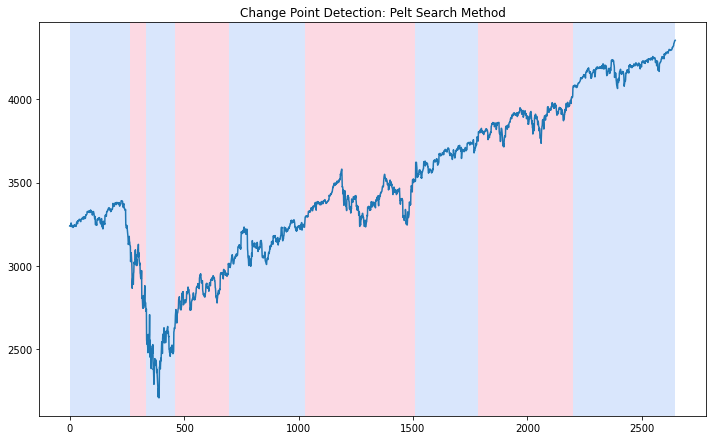

In [26]:
#Changepoint detection with the Pelt search method
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=10)
rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show() 

Binary segmentation search method: This method is arguably the most established in literature (4). Binary segmentation is an approximate method with an efficient computational cost of O (n log n), where n is the number of data points (4). The algorithm works by iteratively applying a single change point method to the entire sequence to determine if a split exists. If a split is detected, then the sequence splits into two sub-sequences (5). The same process is then applied to both sub-sequences, and so on (5). For more info on binary segmentation, check out this paper.

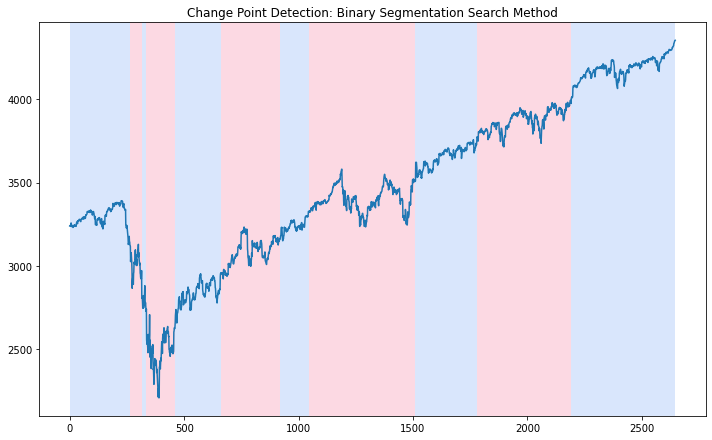

In [27]:
#Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
# show results
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Binary Segmentation Search Method')
plt.show()

Window-based search method: This is a relatively simple approximate search method. The window-based search method “computes the discrepancy between two adjacent windows that move along with signal y” (6). When the two windows are highly dissimilar, a high discrepancy between the two values occurs, which is indicative of a change point (6). Upon generating a discrepancy curve, the algorithm locates optimal change point indices in the sequence (6). For more info on the window-based search method, check out this paper.

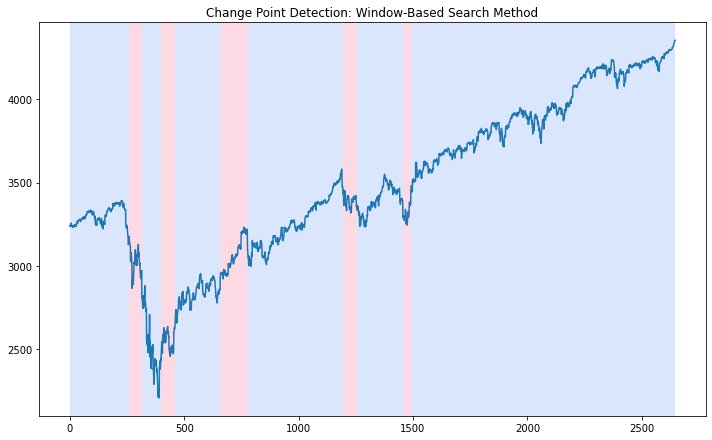

In [28]:
#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=40, model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search Method')
plt.show()

Dynamic programming search method: This is an exact method, which has a considerable computational cost of O(Qn^2 ), where Q is the max number of change points and n is the number of data points (4). For more info on the dynamic programming search method, check out this paper.

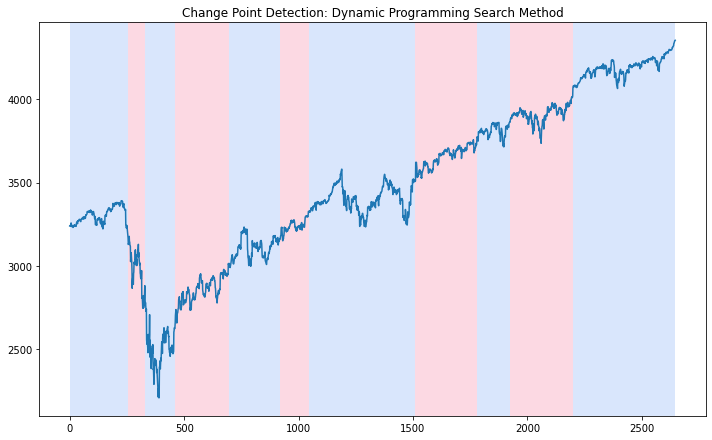

In [29]:
#Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()

As you can see in the graphics above, the detected change points in the sequence differ based on the search method used. The optimal search method depends on what you value most when subsetting the time series. The PELT and dynamic programming methods are both exact (as opposed to approximate) methods, so they are generally more accurate.

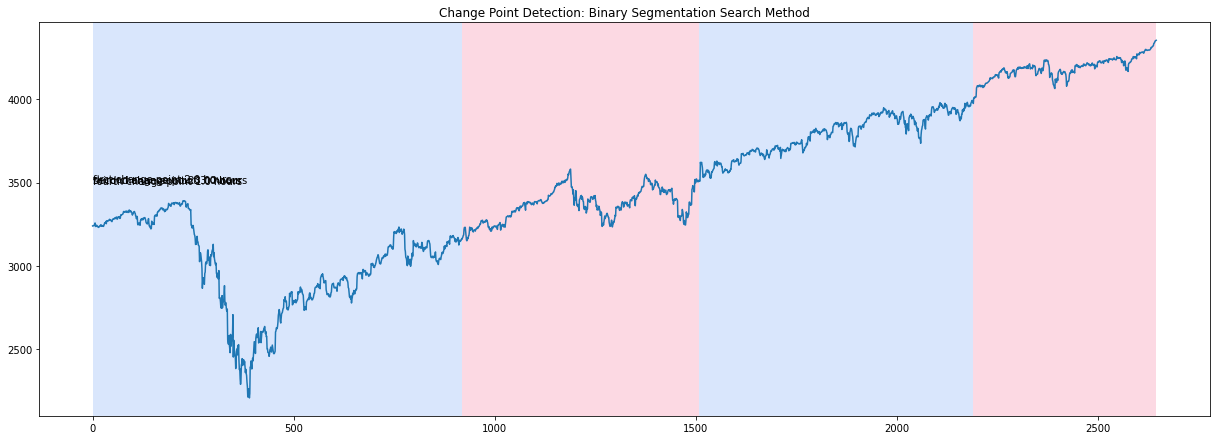

In [37]:
kWmean = ts['Adj Close'].mean()


#Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(n_bkps=3)
# show results
rpt.show.display(points, my_bkps, figsize=(17, 6))

# getting the timestamps of the change points
bkps_timestamps = ts.iloc[[0] + my_bkps[:-1] +[-1]].index

# computing the durations between change points
durations = (bkps_timestamps[1:] - bkps_timestamps[:-1])
#ours
d = durations.seconds/60/60
d_f = pd.DataFrame(d)

oneHr = d_f.values[0][0]
twoHr = d_f.values[1][0]
threeHr = d_f.values[2][0]
fourHr = d_f.values[3][0]

one = f'first change point {oneHr} hours'
two = f'second change point {twoHr} hours'
three = f'third change point {threeHr} hours'
four = f'fourth change point {fourHr} hours'

plt.title('Change Point Detection: Binary Segmentation Search Method')
plt.text(0, kWmean+15, one)
plt.text(0, kWmean+10, two)
plt.text(0, kWmean+5, three)
plt.text(0, kWmean, four)
plt.show()